# Author : Nonbangkok
## Code for : https://www.kaggle.com/datasets/natthananbhukan/thaimnist/data

### Preparation

In [84]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os

### Load Data

In [22]:
df = pd.read_csv("/kaggle/input/thaimnist/mnist.train.map.csv")
df

,id,category
0,75606737-d17d-43eb-86e6-6735b6f45a52.png,8
1,800e3baf-9ab1-48c0-a9ce-46c5fac9ff69.png,1
2,c40b7fc4-07f1-4c78-abac-121bde38e267.png,0
3,1b2e1b3d-46f2-4c3f-b741-a8d5099ce710.png,4
4,b8fd3385-9403-48a4-9d9e-74bde635e688.png,9
...,...,...
8250,9b2af0fb-f1be-4782-a614-23fa59a366d7.png,8
8251,ca58239a-7a35-4c96-9b6a-451e112dc5da.png,6
8252,4ec2ba63-0845-4812-a3fa-1f5eda80de8e.png,8
8253,8479e8d8-d592-4931-926c-17a84b02ad0a.png,2


In [23]:
def load_image(file_path):
    img = tf.io.read_file("/kaggle/input/thaimnist/train/" + file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=(64, 64), method='bicubic')
    img = img / 255.0
    return img

In [24]:
file_paths = df['id'].values
labels = df['category'].values

In [25]:
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

In [26]:
train_images = tf.convert_to_tensor([load_image(file_path) for file_path in train_paths])
train_labels = tf.convert_to_tensor(train_labels)

val_images = tf.convert_to_tensor([load_image(file_path) for file_path in val_paths])
val_labels = tf.convert_to_tensor(val_labels)

In [30]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)

(6604, 64, 64, 3)
(6604,)
(1651, 64, 64, 3)
(1651,)


### Modeling

In [38]:
VGG16(include_top=False, weights='imagenet').summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model = Sequential()

In [36]:
model.add(VGG16(include_top=False, weights="imagenet", input_shape=(64, 64, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,273,418 (58.26 MB)

 Trainable params: 15,273,418 (58.26 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=[SparseCategoricalAccuracy()])

In [74]:
history = model.fit(train_images,train_labels,epochs=30,validation_data = (val_images,val_labels),batch_size=64)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 42s 244ms/step - loss: 2.9518 - sparse_categorical_accuracy: 0.1083 - val_loss: 2.2565 - val_sparse_categorical_accuracy: 0.1502
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 1.9831 - sparse_categorical_accuracy: 0.2463 - val_loss: 1.2247 - val_sparse_categorical_accuracy: 0.5233
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 1.1153 - sparse_categorical_accuracy: 0.5664 - val_loss: 0.7745 - val_sparse_categorical_accuracy: 0.7159
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - loss: 0.6701 - sparse_categorical_accuracy: 0.7528 - val_loss: 0.6338 - val_sparse_categorical_accuracy: 0.7723
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.4856 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.4896 - val_sparse_categorical_accuracy: 0.8401
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 11s 102ms/step - loss: 0.3482 - sparse_categorical_accuracy: 0.8843 - val_loss: 0.4569 - val_sparse_categorical_acc

### Result

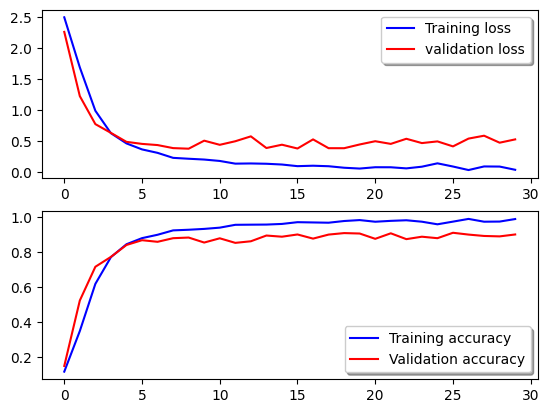

In [82]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['sparse_categorical_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_sparse_categorical_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
y_pred = model.predict(val_images)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = val_labels

conf_matrix = confusion_matrix(y_true, y_pred_classes)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


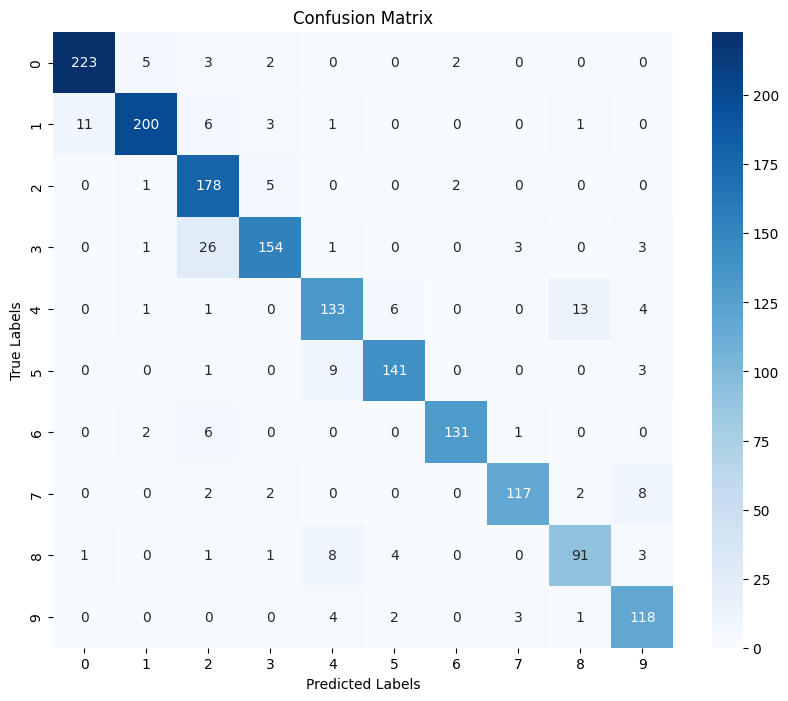

In [88]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(0,10), yticklabels=np.arange(0,10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()